# System Modelling

Author : Masuk  
Help   : Nishi

In [1]:
# Make sure lenstronomy is installed, otherwise install the latest pip version
import h5py  # library to work with '.h5' files
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

try:
    pass
except ModuleNotFoundError:
    !pip install lenstronomy

/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


## Import of standard python libraries

In [2]:
%matplotlib inline

## Load imaging and psf data

In [3]:
with h5py.File("./DESIJ1421-0022_F140W.h5", "r") as f:  # loading image data
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

kwargs_data

{'background_rms': 0.016322818764336215,
 'dec_at_xy_0': -5.639999999999994,
 'exposure_time': array([[392.5919 , 429.8496 , 477.49698, ..., 417.0545 , 626.3687 ,
         470.51013],
        [537.5037 , 481.4545 , 402.75043, ..., 445.28027, 411.41382,
         414.60626],
        [441.50906, 430.91473, 528.3243 , ..., 582.93396, 452.38983,
         456.0343 ],
        ...,
        [455.4104 , 487.22336, 492.4171 , ..., 564.8773 , 450.29538,
         395.7962 ],
        [509.2898 , 384.29117, 459.5256 , ..., 396.0305 , 487.2688 ,
         570.89014],
        [438.19513, 478.61502, 508.9901 , ..., 350.71753, 400.08707,
         430.7757 ]], dtype=float32),
 'image_data': array([[-0.00921469, -0.02078328,  0.00167325, ..., -0.0132964 ,
         -0.03175444, -0.01695797],
        [-0.00559985, -0.01327114, -0.00524183, ...,  0.00243682,
         -0.00851916, -0.01378721],
        [ 0.00427728, -0.00057159, -0.02292269, ..., -0.01166504,
         -0.00735005, -0.00661949],
        ...,
   

In [4]:
with h5py.File("./psf_F140W.h5", "r") as f:  # loading psf data
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"
kwargs_psf

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
         3.2385867e-06, 4.4331632e-06],
        [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
         6.6143798e-06, 4.1430776e-06],
        [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
         5.1404800e-06, 1.7530243e-06],
        ...,
        [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
         5.3933368e-06, 1.6360833e-06],
        [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
         8.7221979e-06, 3.7005334e-06],
        [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
         3.2246478e-06, 5.1252514e-06]], dtype=float32),
 'psf_type': 'PIXEL'}

/tmp/ipykernel_19416/746742490.py:7: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
/tmp/ipykernel_19416/746742490.py:10: RuntimeWarning: invalid value encountered in log10
  axes[1].imshow(np.log10(image), origin="lower", cmap="cubehelix")


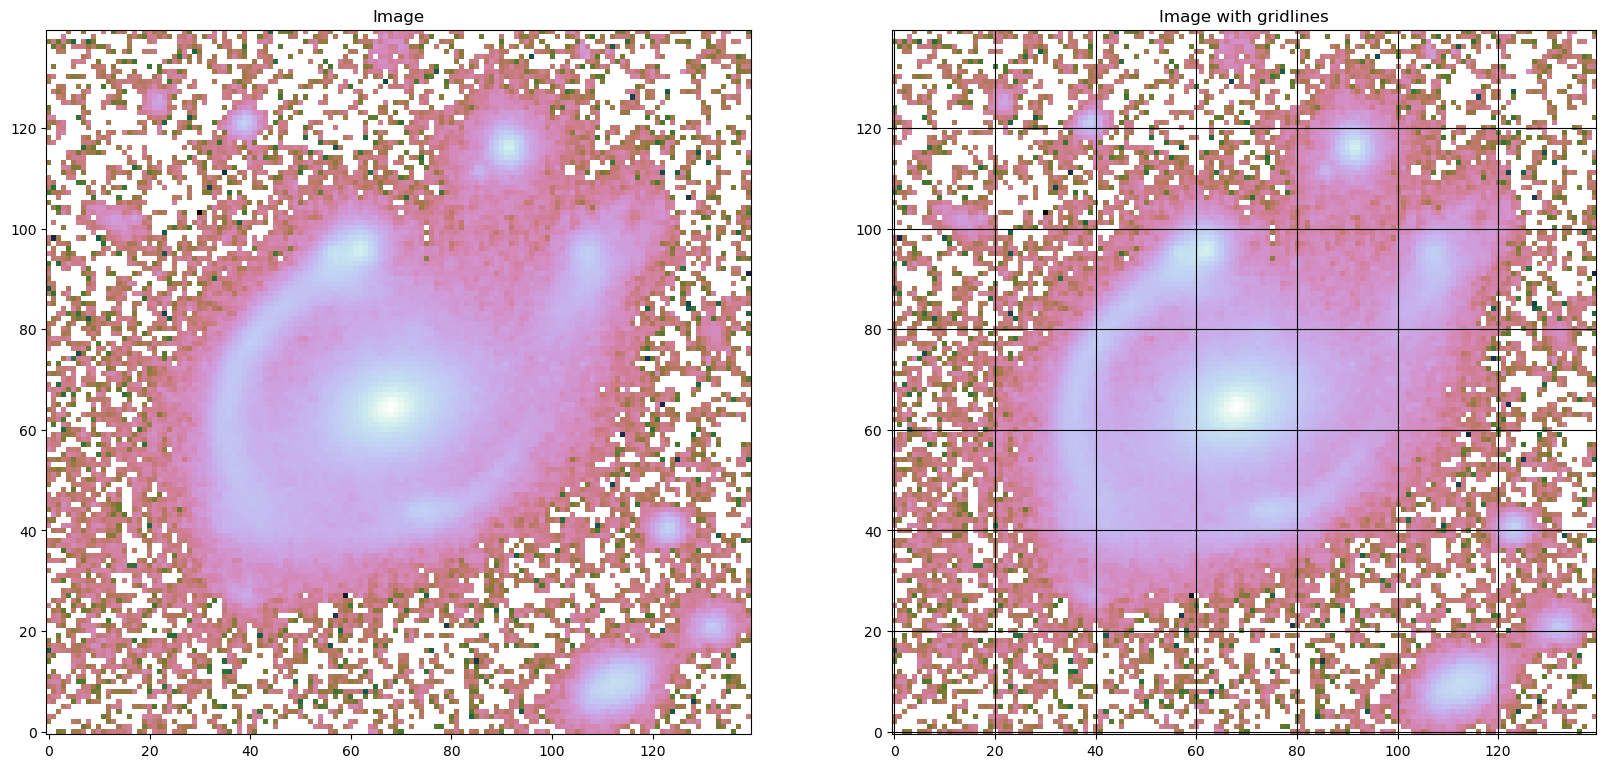

In [5]:
# extracting image_data from kwargs_data
image = kwargs_data["image_data"]

# Make the plot
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[0].set_title("Image")

axes[1].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[1].set_title("Image with gridlines")
axes[1].grid(True, color="black")

# Show the plots
plt.show()

## Masking

In [6]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(image)

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

a = 4.2  # arcsecond (0.8 arcsec = 10 pix)
b = 3.5
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra,
    lens_center_dec,
    a,
    b,
    -np.pi / 4,
)

# 11 o' clock
mask_ext1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.8,
    lens_center_dec + 2,
    0.7,
    0.5,
    -np.pi / 6,
)

# mask_ext1 = mask_util.mask_center_2d(lens_center_ra+0.8,
#                                       lens_center_dec+2.1,
#                                       0.5,
#                                       util.image2array(x_coords),
#                                       util.image2array(y_coords))


# 1 o' clock
mask_ext2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 1.6,
    lens_center_dec + 3.6,
    0.7,
    0.5,
    -np.pi / 6,
)


# mask_ext2 = mask_util.mask_center_2d(lens_center_ra-1.6,
#                                       lens_center_dec+3.7,
#                                       0.5,
#                                       util.image2array(x_coords),
#                                       util.image2array(y_coords))


# 2 o' clock

mask_ext3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.9,
    lens_center_dec + 1.8,
    0.8,
    0.5,
    -np.pi / 3,
)

# mask_ext3 = mask_util.mask_center_2d(lens_center_ra-2.9,
#                                       lens_center_dec+1.8,
#                                       0.4,
#                                       util.image2array(x_coords),
#                                       util.image2array(y_coords))


# 5 o' clock

mask_ext4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.5,
    lens_center_dec - 2.1,
    0.6,
    0.3,
    0,
)

# mask_ext4 = mask_util.mask_center_2d(lens_center_ra-0.5,
#                                       lens_center_dec-2.1,
#                                       0.3,
#                                       util.image2array(x_coords),
#                                       util.image2array(y_coords))


# 7 o' clock
mask_ext5 = mask_util.mask_center_2d(
    lens_center_ra + 2.5,
    lens_center_dec - 3.4,
    0.4,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask = mask_outer * (1 - mask_ext1) * (1 - mask_ext2)
mask = mask * (1 - mask_ext3)
mask = mask * (1 - mask_ext4) * mask_ext5
mask[mask >= 1] = 1
mask[mask < 0] = 0

/tmp/ipykernel_19416/3723066894.py:4: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
/tmp/ipykernel_19416/3723066894.py:14: RuntimeWarning: divide by zero encountered in log10
  image_after_mask = np.log10(image * mask)
/tmp/ipykernel_19416/3723066894.py:14: RuntimeWarning: invalid value encountered in log10
  image_after_mask = np.log10(image * mask)


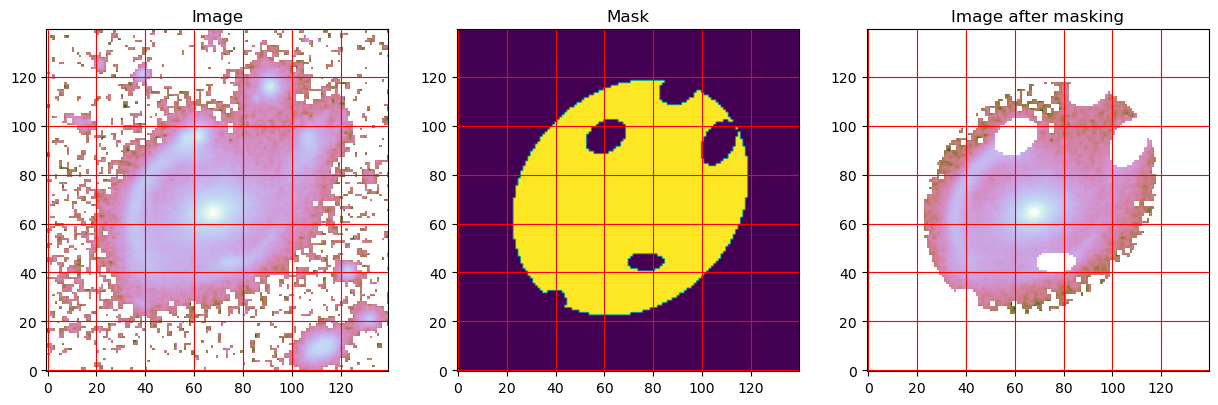

In [18]:
# Setting the subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[0].grid(True, color="red")
axes[0].set_title("Image")

mask = mask.reshape(num_pix, num_pix)

axes[1].imshow(mask, origin="lower")
axes[1].grid(True, color="red")
axes[1].set_title("Mask")

image_after_mask = np.log10(image * mask)

axes[2].imshow(image_after_mask, origin="lower", cmap="cubehelix")
axes[2].grid(True, color="red")
axes[2].set_title("Image after masking")


# Show the plots
plt.show()

## Building a lens model

In [19]:
# adding shear into lens_model_list
lens_model_list = ['EPL', 'SHEAR_GAMMA_PSI']
# adding shapelets into source_model_list
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE","SERSIC_ELLIPSE"]

### Lens galaxy's mass model

In [20]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})

fixed_lens.append({"ra_0": 0, "dec_0": 0})

#EPL
kwargs_lens_init.append(
    {"theta_E": 1.65, "gamma": 1.5, "e1": 0.0, "e2": 0.0, "center_x": 0.0, "center_y": 0.0}
)

kwargs_lens_sigma.append(
    {
        "theta_E": 0.01,
        "gamma": 0.01,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)

kwargs_lower_lens.append(
    {
        "theta_E": 1.2,
        "gamma": 1.2,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)

kwargs_upper_lens.append(
    {"theta_E": 1.7, "gamma": 2.2, "e1": 0.5, "e2": 0.5, "center_x": 10, "center_y": 10}
)




# SHEAR
fixed_lens.append({'ra_0': 0,
                   'dec_0': 0,})
kwargs_lens_init.append({'gamma_ext': 0.20935,
                         'psi_ext': -1.03657,
                         'ra_0': 0,
                         'dec_0': 0})
kwargs_lens_sigma.append({'gamma_ext': 0.05,
                          'psi_ext': 0.1,
                          'ra_0': 0,
                          'dec_0': 0})
kwargs_lower_lens.append({'gamma_ext': 0,
                          'psi_ext': -np.pi/2,
                          'ra_0': -100,
                          'dec_0': -100})
kwargs_upper_lens.append({'gamma_ext': 0.4,
                         'psi_ext': np.pi/2,
                          'ra_0': 100,
                          'dec_0': 100})
lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens,
               kwargs_lower_lens, kwargs_upper_lens]

### Lens galaxy's light model

In [21]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

#1st Sersic profile. lens galaxy's light model
fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.1,
        "n_sersic": 2,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0,
        "amp": 1,
    }
)

kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)

kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.2,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)

kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.4,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)



#2nd Sersic profile. lens galaxy's light model
fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.1,
        "n_sersic": 2,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0,
        "amp": 1,
    }
)

kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)

kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.2,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)

kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.4,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

joint_lens_with_light = [[0, 0, ["center_x", "center_y", "e1", "e2"]]]

joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

### Source galaxy's light model

In [22]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({"n_sersic": 1.0})

kwargs_source_init.append(
    {
        "R_sersic": 0.2,
        "n_sersic": 1,
        "e1": 0,
        "e2": 0,
        "center_x": 0.0,
        "center_y": 0,
        "amp": 5,
    }
)

kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.01,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 10,
    }
)

kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)

kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


fixed_source.append({"n_max": 7})

kwargs_source_init.append({"beta": 1.0, "n_max": 7, "center_x": 0.0, "center_y": 0.0})

kwargs_source_sigma.append({"beta": 10, "n_max": 0.1, "center_x": 0.2, "center_y": 0.2})

kwargs_lower_source.append({"beta": 0.01, "n_max": 2, "center_x": -10, "center_y": -10})

kwargs_upper_source.append({"beta": 100, "n_max": 8, "center_x": 10, "center_y": 10})


joint_centroid = [[0, 1, ["center_x", "center_y"]]]


source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

### Combining all the above specification in the `kwargs_params` dictionary

In [23]:
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_with_light": joint_lens_with_light,
    "joint_source_with_source": joint_centroid,
}

### Numerical settings

In [24]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

# Oversample the image plane by 2 when computing
# the lensed image for better accuracy
kwargs_numerics = {"supersampling_factor": 2, "supersampling_convolution": False}

### Combining all the information to be sent to lenstronomy

In [25]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

## Here the model fitting is done

In [26]:
# using Particle Swarm Optimization
fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 200, "n_iterations": 300}]
]
# ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
# 200, 'sigma_scale': .1}]

# fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200,
#                                 'n_iterations': 100}],
#                       ]


fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    mpi=False,
    verbose=True,
)

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
]

fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list

kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs
output = [
    kwargs_result,
    multi_band_list_out,
    fit_output,
    kwargs_fixed_out,
]


# chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
# kwargs_result = fitting_seq.best_fit(bijective=False)

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
Max iteration reached! Stopping.
-1.379978135774634 reduced X^2 of best position
-4524.258318137137 log likelihood
6557 effective number of data points
[{'theta_E': 1.3559879882826285, 'gamma': 1.3459772378531312, 'e1': 0.13322753925741412, 'e2': -0.32202103353863887, 'center_x': 0.10226895857421794, 'center_y': -0.559738770948425}, {'gamma1': 0.08253688001455424, 'gamma2': -0.2658847448856737, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.2616069815201164, 'n_sersic': 1.0, 'e1': -0.49623058286553534, 'e2': 0.2980989881967432, 'center_x': -4.946359011933119e-05, 'center_y': -0.23260484177084784}, {'amp': 1, 'n_max': 7, 'beta': 0.2426306662829439, 'center_x': -4.946359011933119e-05, 'center_y': -0.23260484177084784}] source result
[{'amp': 1, 'R_sersic': 0.39975857569206646, 'n_sersic': 4.0, 'e1': 0.13322753925741412, 'e2': -0.3220210335386

## Saving the output file

In [19]:
# output_path = f'./DESIJ1421_0022_pso_output.joblib'

# with open(output_path, 'wb') as f:
#     joblib.dump([input, output], f, compress=True)

## Visualizing the fitted model

-1.367671801129727 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.3676718011297129


/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/plot_util.py:273: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cubehelix").copy()
  cmap_new.set_bad(color='k', alpha=1.)
/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/plot_util.py:274: MatplotlibDeprecationWarning: You are modifying the state of a globally registered

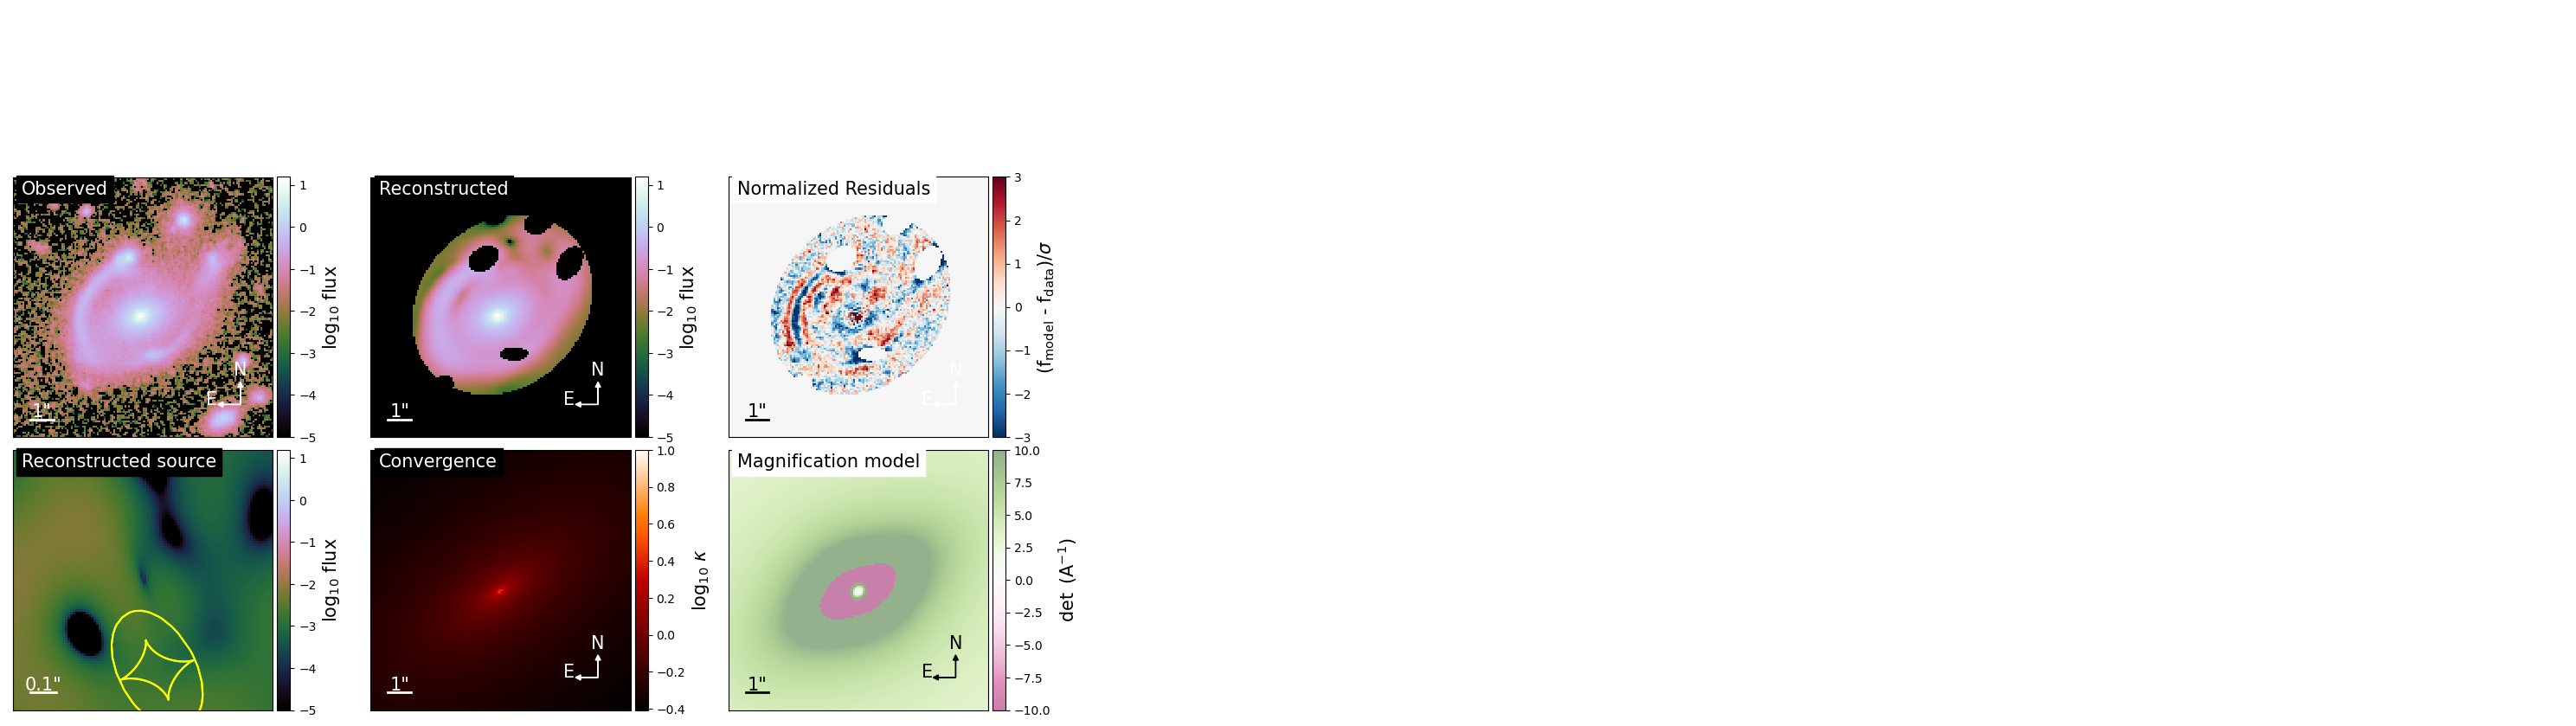

/home/zareef/anaconda3/envs/lens/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:511: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


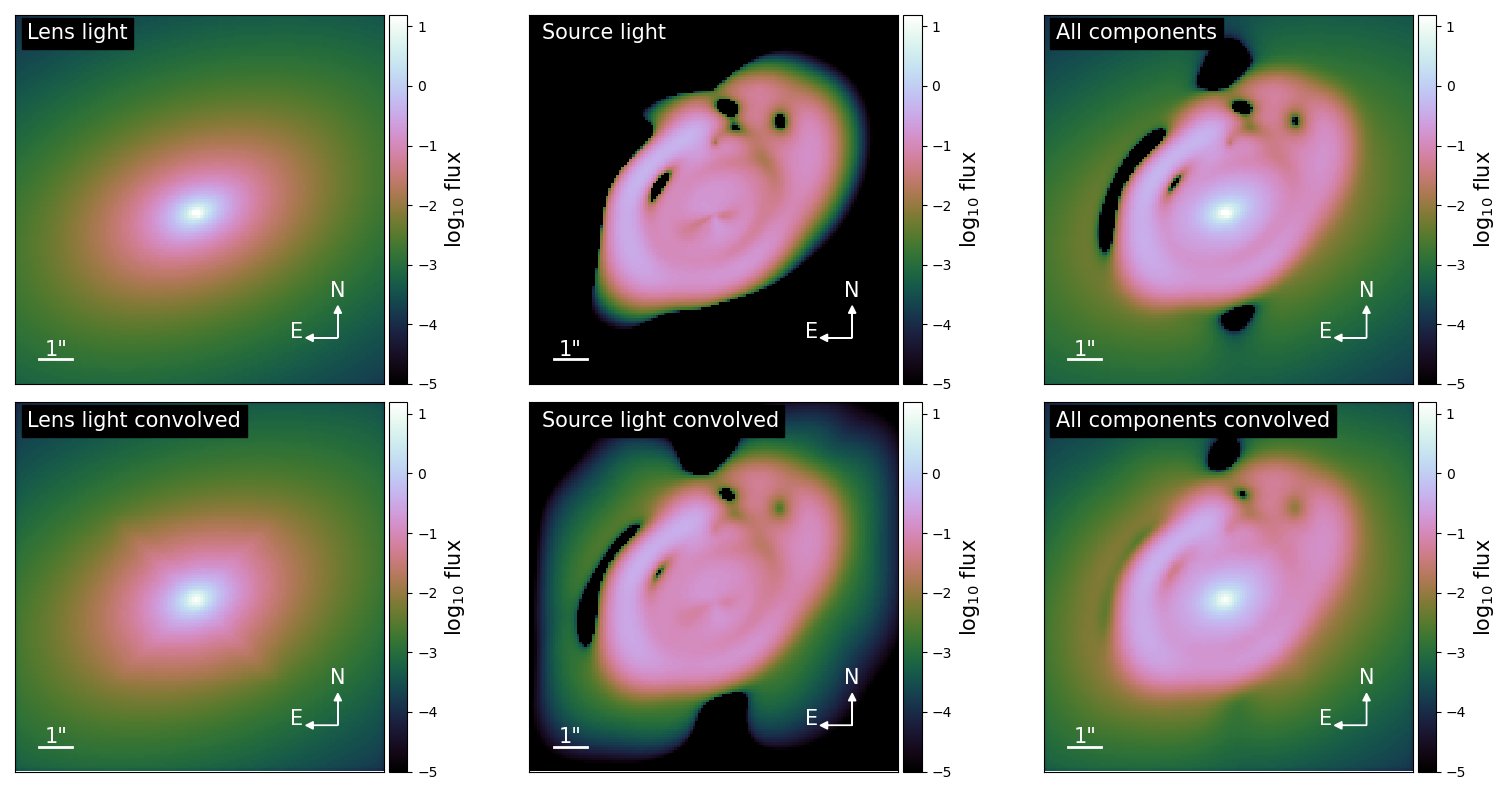

{'kwargs_lens': [{'theta_E': 1.3559879882826285, 'gamma': 1.3459772378531312, 'e1': 0.13322753925741412, 'e2': -0.32202103353863887, 'center_x': 0.10226895857421794, 'center_y': -0.559738770948425}, {'gamma1': 0.08253688001455424, 'gamma2': -0.2658847448856737, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': -9.579634759745732, 'R_sersic': 0.2616069815201164, 'n_sersic': 1.0, 'e1': -0.49623058286553534, 'e2': 0.2980989881967432, 'center_x': -4.946359011933119e-05, 'center_y': -0.23260484177084784}, {'amp': array([101.42860878,  59.31595981,   0.42675301,  58.18364404,
        31.84613591,  40.72509559,  28.44391569,  -1.172351  ,
        11.77101116, -30.00742759,  51.43893084, -21.80905448,
        30.89400336, -15.22504752,  30.85265023,  -5.2456322 ,
       -29.20415031,   4.81806205, -18.31355277,  -1.04010982,
        -9.63939917,   2.24498514,  -2.18644817,  -8.35452397,
        -6.30675149,  17.16824397,   3.18828623,   6.41920099,
       -23.89434419,  13.44417254, -10.38991

In [27]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.01, numPix=100, with_caustics=True
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)